# Research on High-Frequency Trading in the Crypto Market  

## Introduction  
We selected the **crypto market** as our research focus due to its **unique structural characteristics** and **trading dynamics**, which differentiate it from traditional financial markets. Several key factors make crypto an ideal environment for **high-frequency trading (HFT) research**:  

- **High Volatility & Trading Opportunities**  
- **24/7 Trading & Market Microstructure**  
- **Fragmented Market & Arbitrage Potential**  
- **Deep Order Books & High Liquidity in Major Pairs**  
- **Advancements in Infrastructure & API Access**  
- **Evolving Regulatory Landscape & Institutional Involvement**  

## Initial Observations with RSI  
Our study begins with the **Relative Strength Index (RSI)**, a classic technical indicator. However, when applied to **high-frequency data**, we observed several critical issues:  

- **Extreme Volatility:** The high fluctuation of market data results in an **unstable RSI**, leading to excessive trading.  
- **Frequent Trades:** Rapid shifts in RSI values cause **overactive trading**, which can accumulate **significant transaction costs** and **losses**.  
- **False Signals in Extreme Events:** On **January 21, 2022**, a **sharp price drop** occurred, but the RSI falsely signaled a **buy opportunity**, leading to **substantial losses**.  

In [4]:
import pandas as pd
df = pd.read_pickle("data/cpt_5min/k_data/BTCUSD.pkl")

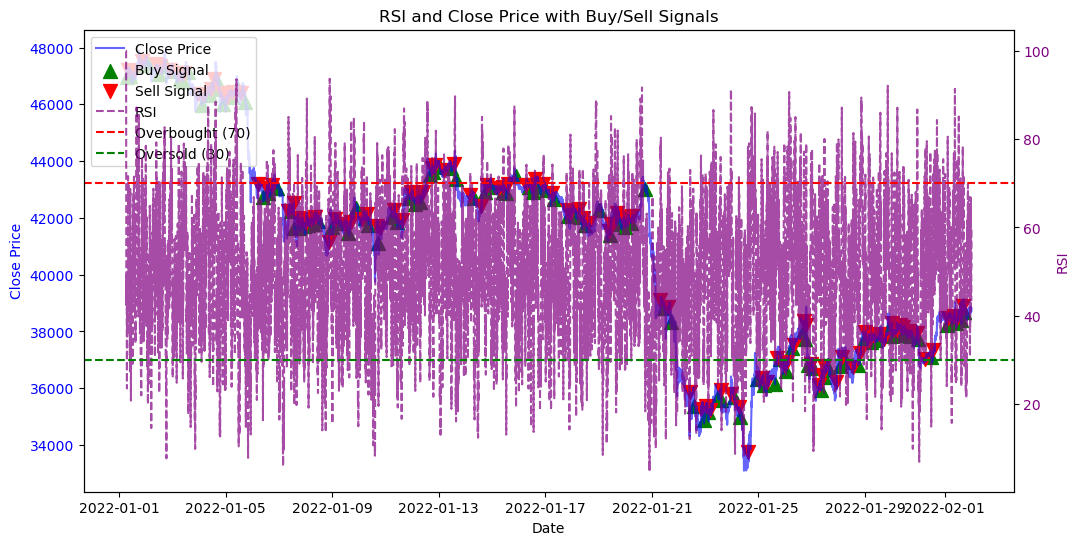

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_rsi(data, period=14):
    """Compute the Relative Strength Index (RSI) using EMA."""
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def backtest_rsi(data, period=14, rsi_buy=30, rsi_sell=70, initial_cash=10000):
    """Backtest an RSI strategy and record buy/sell points."""
    data = data.copy()
    data["RSI"] = calculate_rsi(data["close"], period)
    
    cash = initial_cash
    position = 0
    portfolio = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data["close"].iloc[i]
        rsi = data["RSI"].iloc[i]

        if rsi < rsi_buy and cash > 0:  # Buy condition
            position = cash / price
            cash = 0
            buy_signals.append((data.index[i], price))
        elif rsi > rsi_sell and position > 0:  # Sell condition
            cash = position * price
            position = 0
            sell_signals.append((data.index[i], price))

        portfolio_value = cash + (position * price)  # Track portfolio value
        portfolio.append(portfolio_value)

    data["Portfolio"] = portfolio
    return data, buy_signals, sell_signals

# Load the data
data = df.copy()

data = data[:'2022-2-01']

# Run the RSI backtest
result, buy_signals, sell_signals = backtest_rsi(data)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the closing price
ax1.plot(result.index, result["close"], label="Close Price", color="blue", alpha=0.6)
ax1.set_xlabel("Date")
ax1.set_ylabel("Close Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Plot buy/sell signals (only one legend entry for each)
if buy_signals:
    ax1.scatter(*zip(*buy_signals), marker="^", color="green", label="Buy Signal", s=100)
if sell_signals:
    ax1.scatter(*zip(*sell_signals), marker="v", color="red", label="Sell Signal", s=100)

# Add a secondary y-axis for RSI
ax2 = ax1.twinx()
ax2.plot(result.index, result["RSI"], label="RSI", linestyle="dashed", color="purple", alpha=0.7)
ax2.axhline(70, linestyle="--", color="red", label="Overbought (70)")
ax2.axhline(30, linestyle="--", color="green", label="Oversold (30)")
ax2.set_ylabel("RSI", color="purple")
ax2.tick_params(axis='y', labelcolor="purple")

# Merge legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Keep only one legend entry for Buy and Sell signals
legend_labels = {}
for handle, label in zip(handles1 + handles2, labels1 + labels2):
    if label not in legend_labels:
        legend_labels[label] = handle

ax1.legend(legend_labels.values(), legend_labels.keys(), loc="upper left")

plt.title("RSI and Close Price with Buy/Sell Signals")
plt.show()



To overcome these challenges, we propose an **improved research direction** focusing on optimizing high-frequency trading strategies.  

## Research Objectives  
To enhance the performance of high-frequency trading in crypto markets, our study will explore the following key areas:  

1. **Predicting Intraday Price Jumps**  
   - Develop methods to identify and predict **intraday price jumps** with high probability.  
   - Improve decision-making to reduce **strategy drawdowns** and optimize trade timing.  

2. **Adapting Classic Technical Indicators for High-Frequency Trading**  
   - Modify traditional indicators like RSI to **reduce noise** and enhance signal stability.  
   - Explore alternative smoothing techniques to prevent **excessive trading** due to high volatility.  

3. **Market Regime Adaptability**  
   - Design strategies that can **adjust dynamically** based on market conditions:  
     - **Trending markets (bull/bear trends)**  
     - **Range-bound (sideways) markets**  
   - Implement **adaptive risk management** to handle different volatility environments effectively.  


In [40]:
import importlib
import technical_indicators  

importlib.reload(technical_indicators)

from technical_indicators import TechnicalIndicators

In [41]:
tech_indicators = TechnicalIndicators(df)
df_with_indicators = tech_indicators.get_tech_indicators()

In [52]:
df_with_indicators['Period'] = np.where(df_with_indicators['SMA_50'] > df_with_indicators['SMA_200'], 'uptrend', 'downtrend')

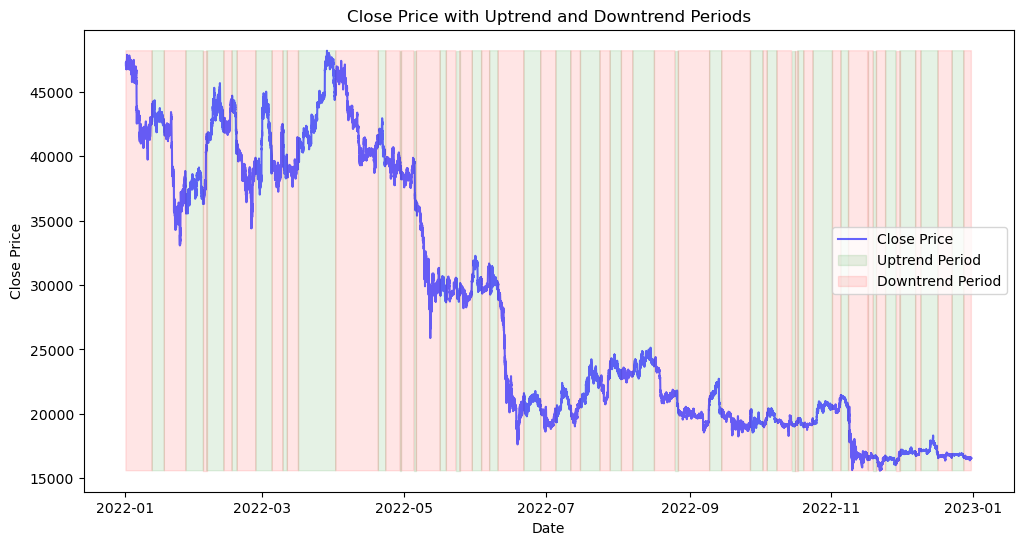

In [53]:
import matplotlib.pyplot as plt

# Define colors for trend periods
colors = {"uptrend": "green", "downtrend": "red"}

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_with_indicators.index, df_with_indicators["close"], label="Close Price", color="blue", alpha=0.6)

# Highlight uptrend and downtrend periods
for period, color in colors.items():
    plt.fill_between(
        df_with_indicators.index,
        df_with_indicators["close"].min(),
        df_with_indicators["close"].max(),
        where=df_with_indicators["Period"] == period,
        color=color,
        alpha=0.1,
        label=f"{period.capitalize()} Period",
    )

# Labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price with Uptrend and Downtrend Periods")
plt.legend()
plt.show()


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to implement the trading strategy
def apply_trading_strategy(df):
    df = df.copy()

    # Initialize positions
    df['Signal_SMA'] = 0  
    df['Signal_EMA'] = 0  
    df['Signal_MACD'] = 0  
    df['Signal_Bollinger'] = 0 
    df['Signal_Stochastic'] = 0  
    df['Signal_RSI'] = 0  

    # Strategy 1: SMA Crossover
    df.loc[df['close'] > df['SMA_20'], 'Signal_SMA'] = 1  # Buy
    df.loc[df['close'] < df['SMA_20'], 'Signal_SMA'] = -1  # Sell

    # Strategy 2: EMA Trend
    df.loc[df['close'] > df['EMA_14'], 'Signal_EMA'] = 1  
    df.loc[df['close'] < df['EMA_14'], 'Signal_EMA'] = -1  

    # Strategy 3: MACD Crossover
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal_MACD'] = 1  
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal_MACD'] = -1  

    # Strategy 4: Bollinger Bands
    df.loc[df['close'] < df['Lower_BB'], 'Signal_Bollinger'] = 1  
    df.loc[df['close'] > df['Upper_BB'], 'Signal_Bollinger'] = -1  

    # Strategy 5: Stochastic Oscillator
    df.loc[(df['%K'] > df['%D']) & (df['%K'] < 20), 'Signal_Stochastic'] = 1  
    df.loc[(df['%K'] < df['%D']) & (df['%K'] > 80), 'Signal_Stochastic'] = -1  

    # Strategy 6: RSI Overbought/Oversold
    df.loc[df['RSI'] < 30, 'Signal_RSI'] = 1  
    df.loc[df['RSI'] > 70, 'Signal_RSI'] = -1  

    return df

# Apply the strategy
df_strategy = apply_trading_strategy(df_with_indicators)


In [57]:
df_strategy

,open,high,low,close,preclose,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,RSI,Period,Position_RSI_LongShort,Position_RSI_LongOnly,Signal_SMA,Signal_EMA,Signal_MACD,Signal_Bollinger,Signal_Stochastic,Signal_RSI
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01 06:00:00,47190.56,47241.08,47119.92,47119.92,NaN,2.436750,1641017099999,114931.6736,153,0.57991700,...,NaN,downtrend,0,0,0,0,0,0,0,0
2022-01-01 06:05:00,47115.80,47280.38,47108.32,47261.43,47119.92,1.418390,1641017399999,66979.3455,113,0.74723500,...,100.000000,downtrend,-1,0,0,1,1,0,0,-1
2022-01-01 06:10:00,47260.56,47331.57,47249.63,47311.32,47261.43,1.963671,1641017699999,92861.0111,134,1.61761000,...,100.000000,downtrend,-1,0,0,1,1,0,0,-1
2022-01-01 06:15:00,47298.17,47298.17,47190.28,47209.46,47311.32,2.039986,1641017999999,96429.3426,79,0.70107400,...,59.480919,downtrend,0,0,0,1,1,0,0,0
2022-01-01 06:20:00,47208.81,47228.06,47169.77,47175.65,47209.46,0.207595,1641018299999,9797.1701,55,0.06055400,...,51.490395,downtrend,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 05:40:00,16541.60,16542.99,16541.58,16541.74,16543.07,0.171651,1672465499999,2839.4793,17,0.06466300,...,41.233703,downtrend,0,0,-1,-1,1,0,0,0
2022-12-31 05:45:00,16543.04,16546.24,16538.06,16539.85,16541.74,9.187929,1672465799999,151989.7736,202,4.32608700,...,37.639404,downtrend,0,0,-1,-1,1,0,0,0
2022-12-31 05:50:00,16539.85,16540.63,16537.96,16537.96,16539.85,0.300884,1672466099999,4976.3609,42,0.04388900,...,34.199621,downtrend,0,0,-1,-1,-1,0,0,0


In [60]:
import trading_signal  

importlib.reload(trading_signal)

from trading_signal import long_short_strategy
from trading_signal import long_only_strategy
from trading_signal import short_only_strategy

# Apply strategies
series_position_long_short = long_short_strategy(df_strategy['Signal_RSI'])
series_position_long_only = long_only_strategy(df_strategy['Signal_RSI'])
series_position_short_only = short_only_strategy(df_strategy['Signal_RSI'])


In [110]:
import importlib
import metrics  

importlib.reload(metrics)

from metrics import evaluate_strategy
from metrics import calculate_cumulative_asset

In [101]:
df_result = calculate_cumulative_asset(df_strategy["close"], series_position_long_short)

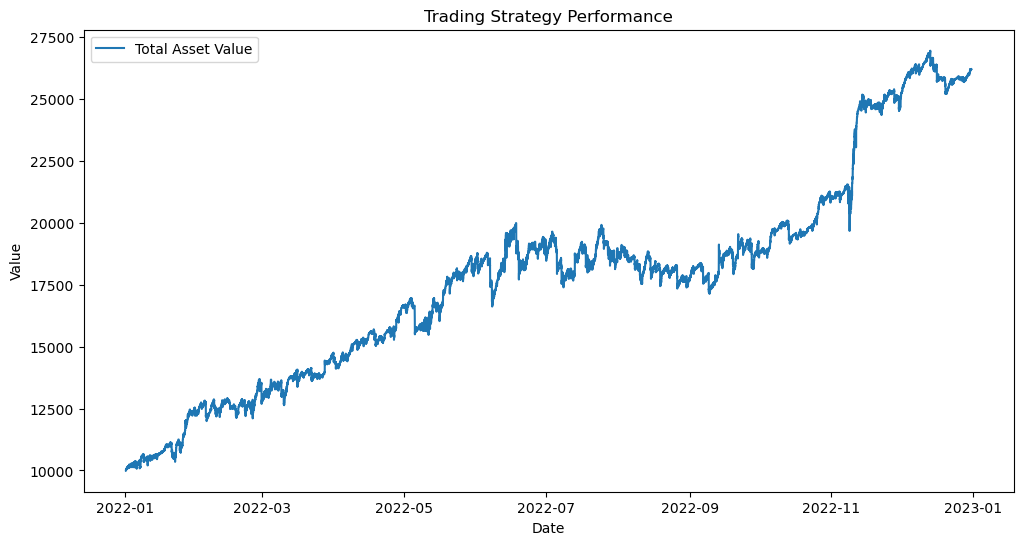

In [103]:
import matplotlib.pyplot as plt

# Plot Total Asset Value, Cash Balance, and Crypto Holdings Value
plt.figure(figsize=(12,6))

# Plot total asset value
plt.plot(df_result.index, df_result["Cumulative_Asset"], label="Total Asset Value")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Trading Strategy Performance")

# Show legend
plt.legend()

# Show the plot
plt.show()


In [104]:
calculate_cumulative_asset(df_strategy["close"], series_position_long_only)

,close,Position,Cumulative_Asset,Cash_Balance,Crypto_Holding
date,,,,,
2022-01-01 06:00:00,47119.92,0,10000.000000,10000.0,0.000000
2022-01-01 06:05:00,47261.43,0,10000.000000,10000.0,0.000000
2022-01-01 06:10:00,47311.32,0,10000.000000,10000.0,0.000000
2022-01-01 06:15:00,47209.46,0,10000.000000,10000.0,0.000000
2022-01-01 06:20:00,47175.65,0,10000.000000,10000.0,0.000000
...,...,...,...,...,...
2022-12-31 05:40:00,16541.74,1,7547.777576,0.0,7547.777576
2022-12-31 05:45:00,16539.85,1,7546.915194,0.0,7546.915194
2022-12-31 05:50:00,16537.96,1,7546.052812,0.0,7546.052812


In [105]:
calculate_cumulative_asset(df_strategy["close"], series_position_short_only)

,close,Position,Cumulative_Asset,Cash_Balance,Crypto_Holding
date,,,,,
2022-01-01 06:00:00,47119.92,0,10000.000000,10000.000000,0.000000
2022-01-01 06:05:00,47261.43,-1,10000.000000,20000.000000,-10000.000000
2022-01-01 06:10:00,47311.32,-1,9989.443823,20000.000000,-10010.556177
2022-01-01 06:15:00,47209.46,-1,10010.996282,20000.000000,-9989.003718
2022-01-01 06:20:00,47175.65,-1,10018.150107,20000.000000,-9981.849893
...,...,...,...,...,...
2022-12-31 05:40:00,16541.74,0,17998.845613,17998.845613,0.000000
2022-12-31 05:45:00,16539.85,0,17998.845613,17998.845613,0.000000
2022-12-31 05:50:00,16537.96,0,17998.845613,17998.845613,0.000000


In [111]:
evaluate_strategy(df_result, risk_free_rate=0.0)

{'Sharpe Ratio': 0.008261191976525868,
 'Max Drawdown (%)': -14.250509448344411,
 'Holding Win Rate (%)': 10.23782040886413,
 'Trading Win Rate (%)': 74.54873646209387,
 'Final Cumulative Return (%)': 161.92709237656717}

In [112]:
df_result['Period'] = df_with_indicators['Period']

In [114]:
evaluate_strategy(df_result[df_result['Period']=='uptrend'], risk_free_rate=0.0)

{'Sharpe Ratio': 0.013174568074908969,
 'Max Drawdown (%)': -13.142578311270562,
 'Holding Win Rate (%)': 10.133657351154314,
 'Trading Win Rate (%)': 75.35575679172058,
 'Final Cumulative Return (%)': 142.95873756152196}

In [115]:
evaluate_strategy(df_result[df_result['Period']=='downtrend'], risk_free_rate=0.0)

{'Sharpe Ratio': 0.011044712409586651,
 'Max Drawdown (%)': -14.250509448344411,
 'Holding Win Rate (%)': 10.374064000537256,
 'Trading Win Rate (%)': 73.9985433357611,
 'Final Cumulative Return (%)': 161.92709237656717}

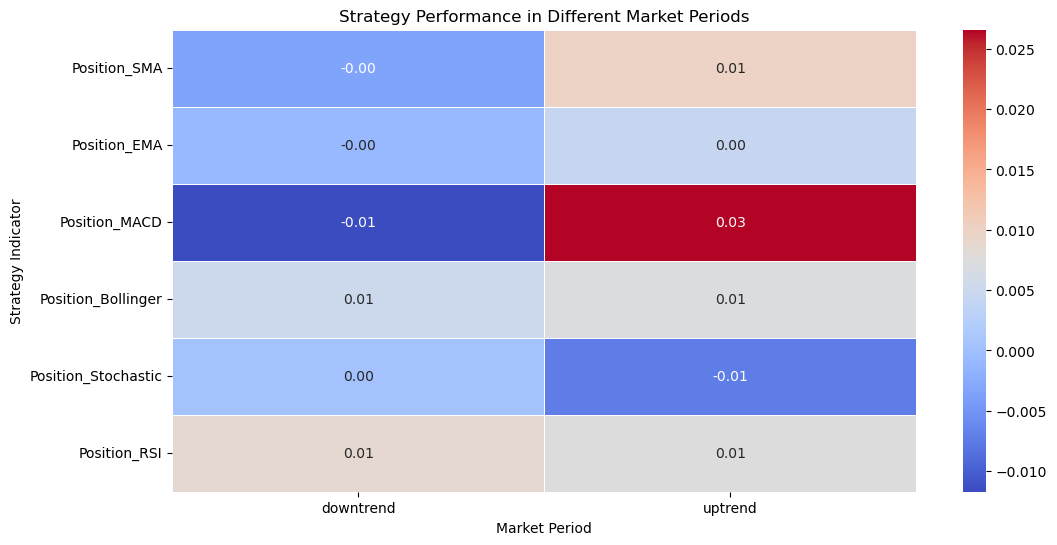

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze performance in different time periods
performance_summary = df_strategy.groupby("Period")[["Position_SMA", "Position_EMA", "Position_MACD", 
                                            "Position_Bollinger", "Position_Stochastic", "Position_RSI"]].mean()

# Plot strategy performance over time
plt.figure(figsize=(12, 6))
sns.heatmap(performance_summary.T, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Strategy Performance in Different Market Periods")
plt.xlabel("Market Period")
plt.ylabel("Strategy Indicator")
plt.show()


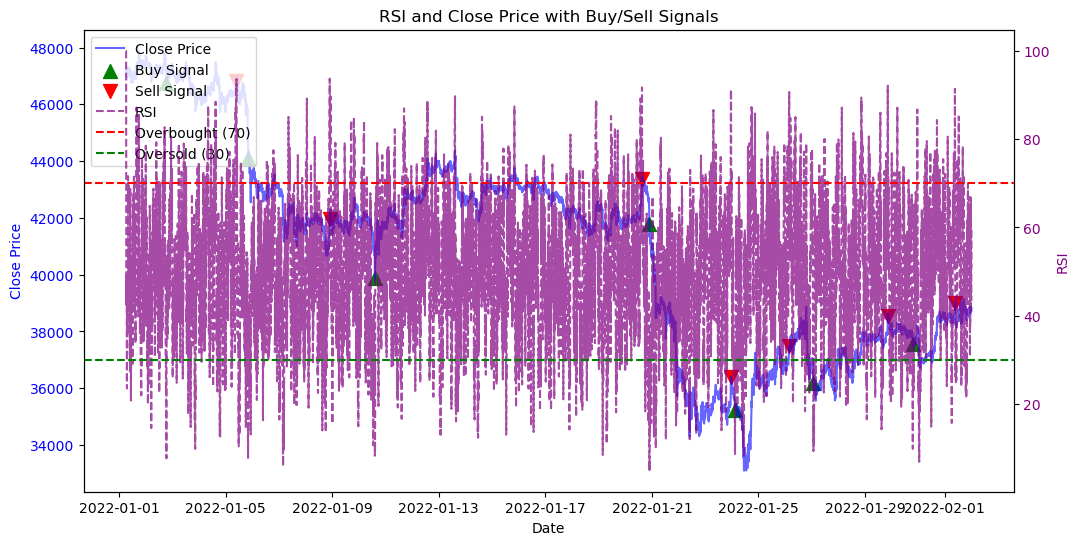

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_rsi(data, period=14):
    """Compute the Relative Strength Index (RSI) using EMA."""
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def backtest_rsi(data, period=14, rsi_buy=10, rsi_sell=90, initial_cash=10000):
    """Backtest an RSI strategy and record buy/sell points."""
    data = data.copy()
    data["RSI"] = calculate_rsi(data["close"], period)
    
    cash = initial_cash
    position = 0
    portfolio = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data["close"].iloc[i]
        rsi = data["RSI"].iloc[i]

        if rsi < rsi_buy and cash > 0:  # Buy condition
            position = cash / price
            cash = 0
            buy_signals.append((data.index[i], price))
        elif rsi > rsi_sell and position > 0:  # Sell condition
            cash = position * price
            position = 0
            sell_signals.append((data.index[i], price))

        portfolio_value = cash + (position * price)  # Track portfolio value
        portfolio.append(portfolio_value)

    data["Portfolio"] = portfolio
    return data, buy_signals, sell_signals

# Load the data
data = df.copy()

data = data[:'2022-2-01']

# Run the RSI backtest
result, buy_signals, sell_signals = backtest_rsi(data)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the closing price
ax1.plot(result.index, result["close"], label="Close Price", color="blue", alpha=0.6)
ax1.set_xlabel("Date")
ax1.set_ylabel("Close Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Plot buy/sell signals (only one legend entry for each)
if buy_signals:
    ax1.scatter(*zip(*buy_signals), marker="^", color="green", label="Buy Signal", s=100)
if sell_signals:
    ax1.scatter(*zip(*sell_signals), marker="v", color="red", label="Sell Signal", s=100)

# Add a secondary y-axis for RSI
ax2 = ax1.twinx()
ax2.plot(result.index, result["RSI"], label="RSI", linestyle="dashed", color="purple", alpha=0.7)
ax2.axhline(70, linestyle="--", color="red", label="Overbought (70)")
ax2.axhline(30, linestyle="--", color="green", label="Oversold (30)")
ax2.set_ylabel("RSI", color="purple")
ax2.tick_params(axis='y', labelcolor="purple")

# Merge legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Keep only one legend entry for Buy and Sell signals
legend_labels = {}
for handle, label in zip(handles1 + handles2, labels1 + labels2):
    if label not in legend_labels:
        legend_labels[label] = handle

ax1.legend(legend_labels.values(), legend_labels.keys(), loc="upper left")

plt.title("RSI and Close Price with Buy/Sell Signals")
plt.show()

在存在趋势的crypto市场中，使用RSI会存在买入卖出不及时的情况。而我们的目的是做短线交易，应该避免长时间持仓